# Explore here

In [ ]:
# Useful for errors in library compatibility
# %pip install numpy==1.23.5 scipy cython
# %pip install pmdarima

In [30]:
# Basics
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Analytics for time series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Models
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# Metrics
from sklearn.metrics import mean_squared_error, r2_score

# Utils
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
# Get data
ts = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv")
ts

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633
...,...,...
361,2023-08-30 17:10:08.079328,989.600354
362,2023-08-31 17:10:08.079328,994.987326
363,2023-09-01 17:10:08.079328,995.814415
364,2023-09-02 17:10:08.079328,997.350214


In [4]:
# Convert date column to datetime type
ts["date"] = pd.to_datetime(ts["date"])
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    366 non-null    datetime64[ns]
 1   sales   366 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


In [5]:
# Redefine series index
ts = ts.set_index("date")
ts

,sales
date,
2022-09-03 17:10:08.079328,55.292157
2022-09-04 17:10:08.079328,53.803211
2022-09-05 17:10:08.079328,58.141693
2022-09-06 17:10:08.079328,64.530899
2022-09-07 17:10:08.079328,66.013633
...,...
2023-08-30 17:10:08.079328,989.600354
2023-08-31 17:10:08.079328,994.987326
2023-09-01 17:10:08.079328,995.814415


In [6]:
# Ensure chronology of the series 
ts = ts.sort_index()
ts

,sales
date,
2022-09-03 17:10:08.079328,55.292157
2022-09-04 17:10:08.079328,53.803211
2022-09-05 17:10:08.079328,58.141693
2022-09-06 17:10:08.079328,64.530899
2022-09-07 17:10:08.079328,66.013633
...,...
2023-08-30 17:10:08.079328,989.600354
2023-08-31 17:10:08.079328,994.987326
2023-09-01 17:10:08.079328,995.814415


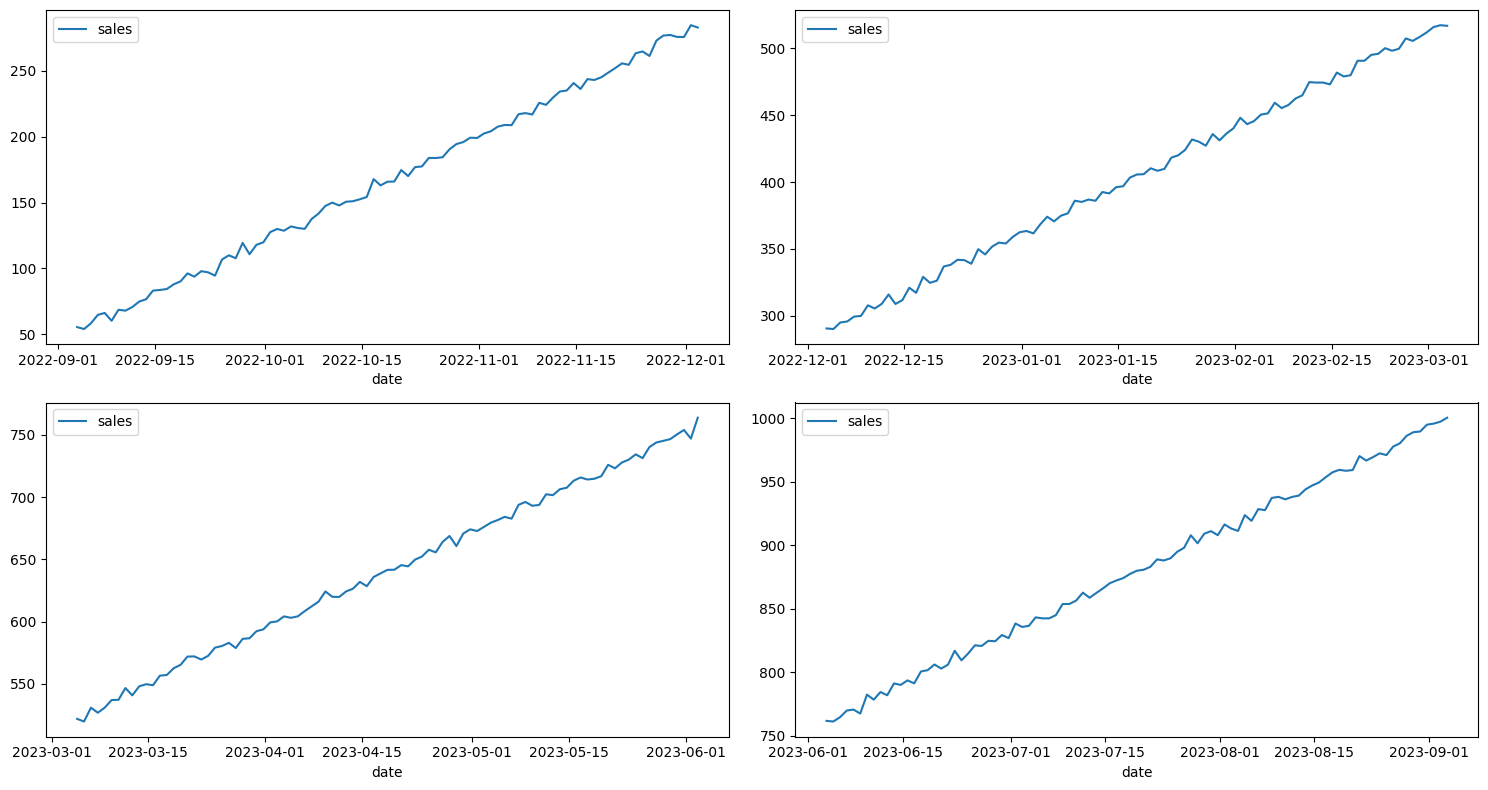

In [7]:
fig, axis = plt.subplots(2,2,figsize = (15, 8))

sns.lineplot(ax=axis[0,0], data = ts.iloc[0:91])
sns.lineplot(ax=axis[0,1], data = ts.iloc[91:182])
sns.lineplot(ax=axis[1,0], data = ts.iloc[182:273])
sns.lineplot(ax=axis[1,1], data = ts.iloc[273:])

plt.tight_layout()

plt.show()

We plotted the series in 4 plots, seeking to visually capture seasonal patterns. It clearly has an upward trend, and no repeating patterns are visible over time. We will use period 7 for our decomposition, looking for any weekly patterns, and an additive model, since seasonal patterns remain constant.

In [8]:
decomposition = seasonal_decompose(ts, model="additive", period=7)
decomposition

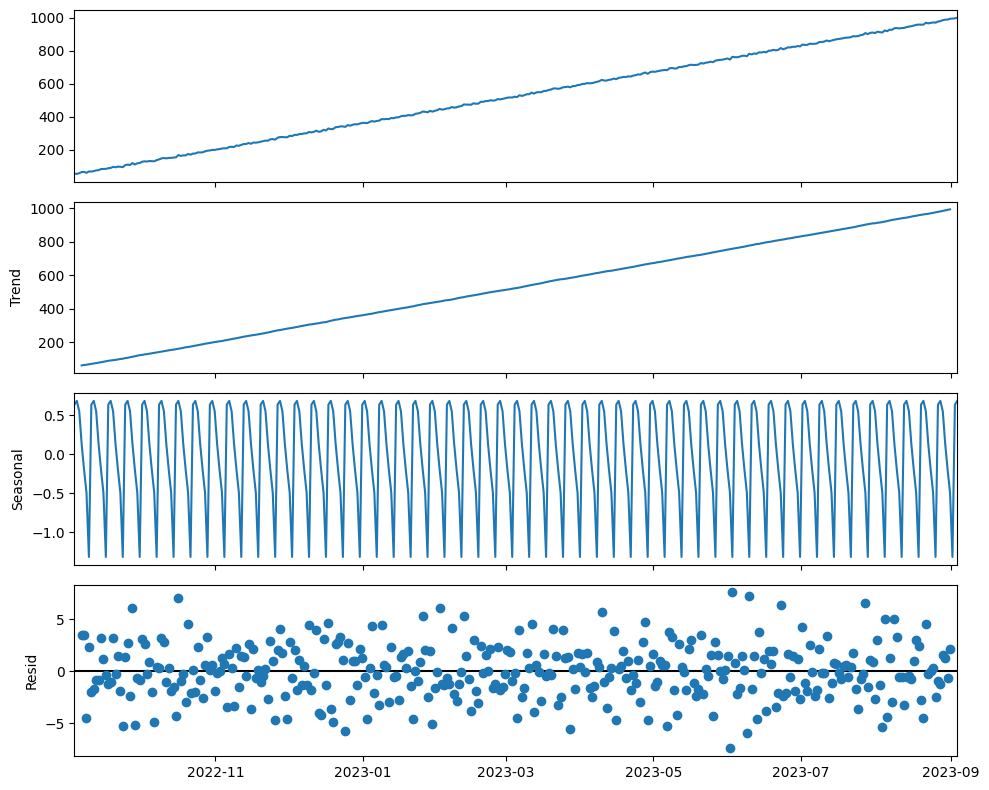

In [9]:
# Graficar los componentes
fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.tight_layout()
plt.show()

Graphic Analysis
- Clear and fairly constant upward trend
- 7-day clear pattern
- Scattered residuals with no clear pattern

In [10]:
# Search for stationarity
def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

In [11]:
test_stationarity(ts)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

p-value is greater than 0.05, this means that our null hypothesis will be rejected and we will take this series as non-stationary

In [12]:
ts_diff = ts.copy()

In [13]:
# Differentiate the series to remove trend
ts_diff['sales'] = ts_diff['sales'].diff()
ts_diff = ts_diff.dropna()

In [14]:
test_stationarity(ts_diff)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

p-value less than 0.05, our differenced series is stationary with a single differentiation

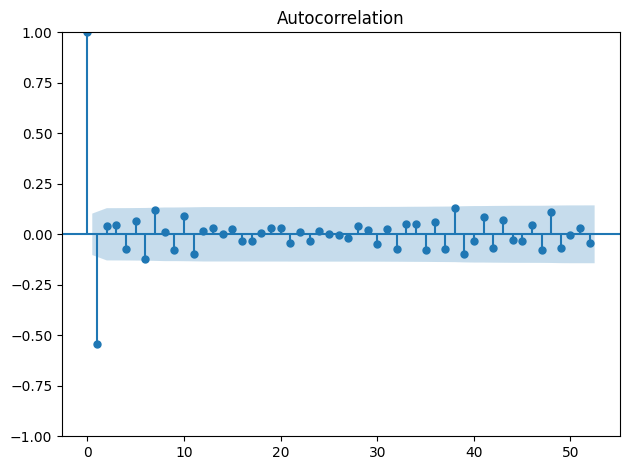

In [15]:
# Graficar ACF
plot_acf(ts_diff, lags=52) # Cada lag una semana (datos de un año)
plt.tight_layout()
plt.show()

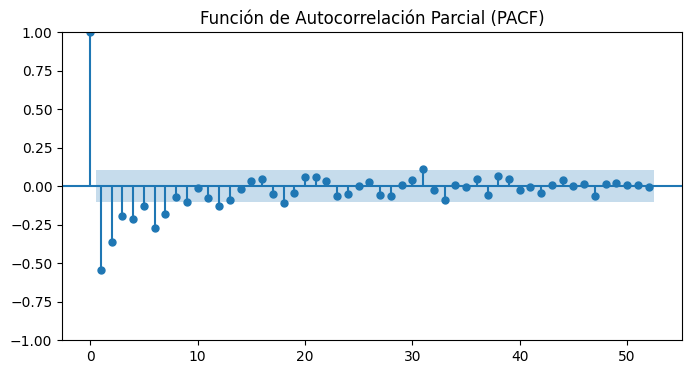

In [16]:
# Graficar PACF
plt.figure(figsize=(8, 4))
plot_pacf(ts_diff, lags=52, ax=plt.gca())
plt.title('Función de Autocorrelación Parcial (PACF)')
plt.show()

Parameter selection:

- d=1 because the original series required differentiation to achieve stationarity
- p=1 was determined by the presence of a significant spike in lag 1 of the PACF of the differentiated series that then cuts
- q=1 was included due to the presence of a significant spike in lag 1 of the ACF of the differentiated series

In [17]:
p = 1
d = 1
q = 1

train = ts[:-60]
test = ts[-60:]

modelo_arima = ARIMA(train, order=(p,d,q))

resultado_arima = modelo_arima.fit()

In [18]:
predicciones = resultado_arima.forecast(60)
predicciones

2023-07-06 17:10:08.079328    845.010569
2023-07-07 17:10:08.079328    847.567679
2023-07-08 17:10:08.079328    850.124789
2023-07-09 17:10:08.079328    852.681898
2023-07-10 17:10:08.079328    855.239006
2023-07-11 17:10:08.079328    857.796113
2023-07-12 17:10:08.079328    860.353219
2023-07-13 17:10:08.079328    862.910324
2023-07-14 17:10:08.079328    865.467428
2023-07-15 17:10:08.079328    868.024531
2023-07-16 17:10:08.079328    870.581634
2023-07-17 17:10:08.079328    873.138735
2023-07-18 17:10:08.079328    875.695835
2023-07-19 17:10:08.079328    878.252935
2023-07-20 17:10:08.079328    880.810033
2023-07-21 17:10:08.079328    883.367130
2023-07-22 17:10:08.079328    885.924227
2023-07-23 17:10:08.079328    888.481323
2023-07-24 17:10:08.079328    891.038417
2023-07-25 17:10:08.079328    893.595511
2023-07-26 17:10:08.079328    896.152604
2023-07-27 17:10:08.079328    898.709696
2023-07-28 17:10:08.079328    901.266787
2023-07-29 17:10:08.079328    903.823877
2023-07-30 17:10

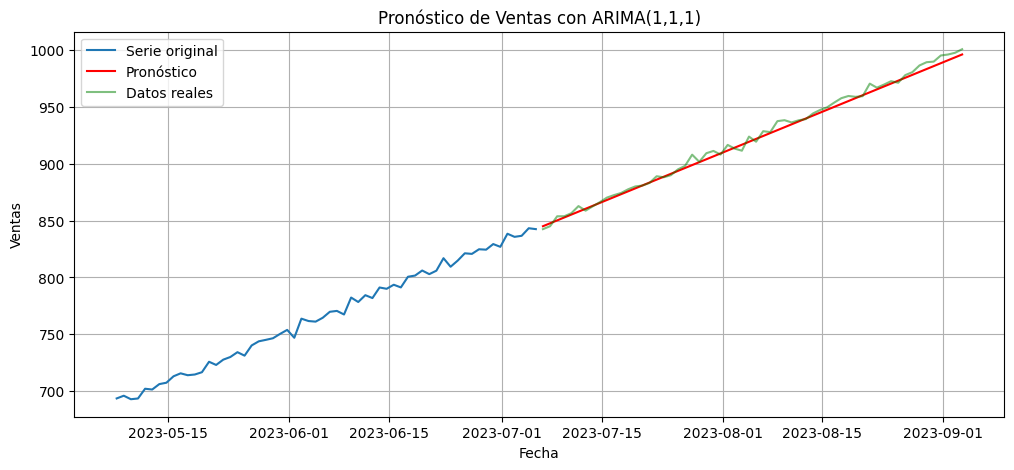

In [27]:
# Graficar pronóstico
plt.figure(figsize=(12,5))
plt.plot(train[-60:], label='Serie original')
plt.plot(predicciones, label='Pronóstico', color='red')
plt.plot(test, label="Datos reales", color="green", alpha=0.5)
plt.title("Pronóstico de Ventas con ARIMA(1,1,1)")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
model = auto_arima(train, seasonal = True, trace = True, m = 7)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=1547.803, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=1762.723, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1653.866, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=1542.086, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=1853.658, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=1546.075, Time=0.08 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=1760.315, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=1541.599, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=1545.060, Time=0.18 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=1542.216, Time=0.81 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=1541.412, T

In [24]:
forecast = model.predict(60)
forecast

2023-07-06 17:10:08.079328     847.299421
2023-07-07 17:10:08.079328     848.933135
2023-07-08 17:10:08.079328     852.433103
2023-07-09 17:10:08.079328     854.837624
2023-07-10 17:10:08.079328     856.319599
2023-07-11 17:10:08.079328     860.821962
2023-07-12 17:10:08.079328     862.248876
2023-07-13 17:10:08.079328     864.576765
2023-07-14 17:10:08.079328     867.087171
2023-07-15 17:10:08.079328     870.769335
2023-07-16 17:10:08.079328     872.271309
2023-07-17 17:10:08.079328     875.449810
2023-07-18 17:10:08.079328     877.453380
2023-07-19 17:10:08.079328     880.316877
2023-07-20 17:10:08.079328     883.475507
2023-07-21 17:10:08.079328     886.097803
2023-07-22 17:10:08.079328     887.746843
2023-07-23 17:10:08.079328     891.316110
2023-07-24 17:10:08.079328     893.400649
2023-07-25 17:10:08.079328     896.527129
2023-07-26 17:10:08.079328     898.890704
2023-07-27 17:10:08.079328     900.992379
2023-07-28 17:10:08.079328     903.569956
2023-07-29 17:10:08.079328     907

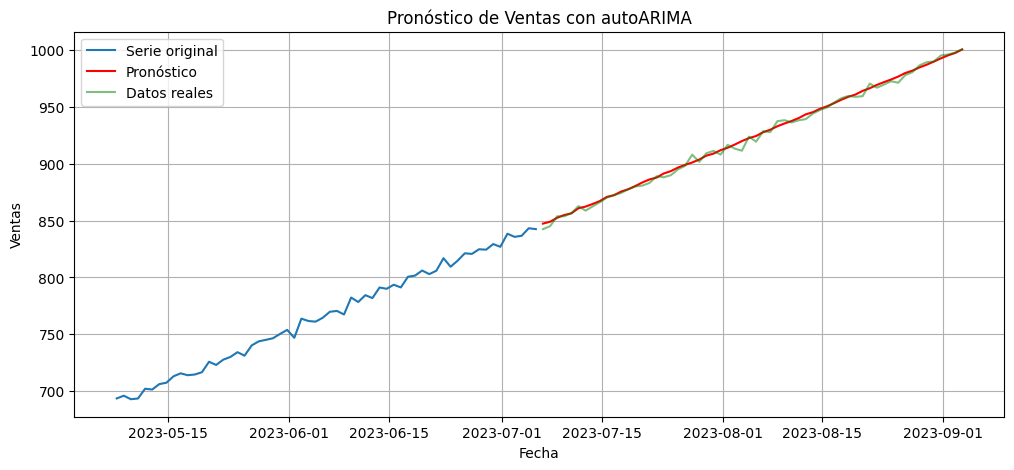

In [29]:
# Graficar pronóstico
plt.figure(figsize=(12,5))
plt.plot(train[-60:], label='Serie original')
plt.plot(forecast, label='Pronóstico', color='red')
plt.plot(test, label="Datos reales", color="green", alpha=0.5)
plt.title("Pronóstico de Ventas con autoARIMA")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.legend()
plt.grid(True)
plt.show()

In [32]:
# Arima manual
mse_manual = mean_squared_error(test, predicciones)
r2_score_manual = r2_score(test, predicciones)
rmse_manual = np.sqrt(mse_manual)

# Auto Arima
mse_auto = mean_squared_error(test, forecast)
r2_score_auto = r2_score(test, forecast)
rmse_auto = np.sqrt(mse_auto)
print("MANUAL")
print("MSE manual: ", mse_manual)
print("R2 Score manual: ",r2_score_manual)
print("RMSE manual: ", rmse_manual)
print()
print("AUTO-ARIMA")
print("MSE auto: ", mse_auto)
print("R2 Score auto: ",r2_score_auto)
print("RMSE auto: ", rmse_auto)

MANUAL
MSE manual:  12.935653551877099
R2 Score manual:  0.9937309867701621
RMSE manual:  3.5966169592934274

AUTO-ARIMA
MSE auto:  7.8682923093433494
R2 Score auto:  0.9961867849671695
RMSE auto:  2.8050476483196056


**CONCLUSIONS**

Manual and automatic modeling yield very good results, with one clear winner: auto_arima, which achieves better metrics with its parameter search and optimization. However, manual search provides us with an understanding of the data and how it behaves over time, serving as a good starting point.